# Face Detection among images

In [1]:
# loading libraries
import os
import joblib
from collections import Counter

from skimage.io import imread
from skimage.transform import resize

import numpy as np

import matplotlib.pyplot as plt

### Data resizing

In [2]:
def resize_data(path, pklname, include, width=150, height=None):
    """
    load images from path, resize them and write them as arrays to a dictionary,
    together with labels and metadata. The dictionary is written to a pickle file
    named '{pklname}_{width}x{height}px.pkl'.
    
    Parameter
    ---------
    src: str
        path to data
    pklname: str
        path to output file
    width: int
        target width of the image in pixels
    include: set[str]
        set containing str
    """
    height = height if height is not None else width
    data = dict()
    data['description'] = 'resized ({0}x{1})animal images in rgb'.format(int(width), int(height))
    data['label'] = []
    data['filename'] = []
    data['data'] = []
    
    pklname = f"Output/{pklname}_{width}x{height}px.pkl"
    for subdir in os.listdir(path):
        if subdir in include:
            print(subdir)
            current_path = os.path.join(path, subdir)
            
            for file in os.listdir(current_path):
                if file[-3:] in {'jpg', 'png'}:
                    im = imread(os.path.join(current_path, file))
                    im = resize(im, (width, height)) #[:,:,::-1]
                    data['label'].append(subdir[:-4])
                    data['filename'].append(file)
                    data['data'].append(im)
        joblib.dump(data, pklname)
    return data

In [3]:
data_path = r'C:\Users\straw\Desktop\AIS\ProjectPool 2\Classification-images\AnimalFace'
print(os.listdir(data_path))

['BearHead', 'CatHead', 'ChickenHead', 'CowHead', 'DeerHead', 'DogHead', 'DuckHead', 'EagleHead', 'ElephantHead', 'HumanHead', 'LionHead', 'MonkeyHead', 'MouseHead', 'Natural', 'PandaHead', 'PigeonHead', 'PigHead', 'RabbitHead', 'SheepHead', 'TigerHead', 'WolfHead']


In [4]:
pklname = 'output'
width = 80
 
include = {'CatHead', 'BearHead', 'ElephantHead', 
           'EagleHead', 'DeerHead', 'WolfHead', 'PandaHead'}

resize_data(path=data_path, pklname=pklname, include=include, width=width)

BearHead
CatHead
DeerHead
EagleHead
ElephantHead
PandaHead
WolfHead


{'description': 'resized (80x80)animal images in rgb',
 'label': ['Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bea

In [5]:
data = joblib.load(f'Output/{pklname}_{width}x{width}px.pkl')
 
print('Number of samples: ', len(data['data']))
print('Keys: ', list(data.keys()))
print('Description: ', data['description'])
print('Images shape: ', data['data'][0].shape)
print('Labels:', np.unique(data['label']))

Number of samples:  775
Keys:  ['description', 'label', 'filename', 'data']
Description:  resized (80x80)animal images in rgb
Images shape:  (80, 80, 3)
Labels: ['Bear' 'Cat' 'Deer' 'Eagle' 'Elephant' 'Panda' 'Wolf']


In [6]:
Counter(data['label'])

Counter({'Bear': 101,
         'Cat': 159,
         'Deer': 101,
         'Eagle': 97,
         'Elephant': 100,
         'Panda': 117,
         'Wolf': 100})

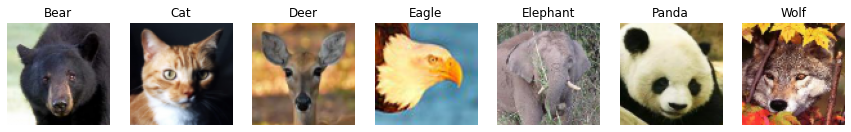

In [7]:
labels = np.unique(data['label'])

fig, axes = plt.subplots(1, len(labels))
fig.set_size_inches(15,4)
for ax, label in zip(axes, labels):
    idx = data['label'].index(label)
    ax.imshow(data['data'][idx])
    ax.axis('off')
    ax.set_title(label)

In [8]:
X = np.array(data['data'])
y = np.array(data['label'])